In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType

from torch.nn import Transformer
from torch.nn import Transformer_1dcnn





from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()


        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])

        
        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        print(src_v.shape)
        self.src_v = src_v
        print(src_c.shape)
        self.src_c = src_c
        self.trg = trg

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [3]:
# mm_scaler = MinMaxScaler()

# class StrideDataset(Dataset):
#     def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
#         df = pd.read_csv(file_path)
        
#         self.soc = df.iloc[x_size:, 20:21].values #SoC
#         self.soc = self.soc.squeeze()
#         self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
#         self.soc = self.soc.squeeze()

#         self.src_v = df.iloc[x_size:, 7:8].values #V
#         self.src_v = self.src_v.squeeze()
#         self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
#         self.src_v = self.src_v.squeeze()

#         self.src_c = df.iloc[x_size:, 6:7].values #I
#         self.src_c = self.src_c.squeeze()
#         self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
#         self.src_c = self.src_c.squeeze()


#         self.length = len(df) - x_size

#         num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
#         src_v = np.zeros([enc_seq_len, num_samples])
#         src_c = np.zeros([enc_seq_len, num_samples])
#         trg = np.zeros([target_seq_len, num_samples])

        
#         for i in np.arange(num_samples):
#             start_x = stride*i
#             end_x = start_x + enc_seq_len
#             src_v[:,i] = self.src_v[start_x:end_x]
#             src_c[:,i] = self.src_c[start_x:end_x]

#             start_y = stride*i + enc_seq_len
#             end_y = start_y + target_seq_len
#             trg[:,i] = self.soc[start_y:end_y]

#         src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
#         src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
#         trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

#         print(src_v.shape)
#         self.src_v = src_v
#         print(src_c.shape)
#         self.src_c = src_c
#         self.trg = trg

#         self.len = len(src_v)

#     def __getitem__(self, i):
#         return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
#     def __len__(self):
#         return self.len

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 20:21].values
        
        self.length = len(df) - x_size

    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [5]:
train_dataset_1 = StrideDataset("DST_80.csv", 50, 20, 1919, stride=5)
train_dataset_2 = StrideDataset("US06_80.csv", 50, 20, 1207, stride=5)
# train_dataset_1 = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=5)
# train_dataset_2 = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=5)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])
# train_dataset = train_dataset_2


train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
# dataset_d = CustomDataset("DST_80.csv", 1919)

(2114, 50, 1)
(2114, 50, 1)
(2125, 50, 1)
(2125, 50, 1)


In [6]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()

        # self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        
        # self.linear = nn.Linear(d_model, 1)
        # self.pos_encoder = PositionalEncoding(d_model, dropout)

        # self.encoder = nn.Linear(1, d_model)

        self.coder_in = nn.Linear(1,d_model)
        
        self.conv_in = nn.Sequential(
            nn.Conv1d(1, d_model, kernel_size=15),
            nn.Softmax(dim=1),
            nn.Linear(50-15+1, 50) #src-ker+1, src
        )
        
        self.coder_in2 = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )
        
        # self.conv_in_dec = nn.Sequential(
        #     nn.Conv1d(1,500,kernel_size=15),
        #     nn.Softmax(dim=1),
        #     nn.Linear(20-15, 20-1) #dec-ker, dec-1
        # )
        
        
        # self.conv_out = nn.Sequential(
        #     nn.Conv1d(500,50,kernel_size=5,stride=3),
        #     #nn.ReLU(),
        #     nn.Conv1d(50,1,kernel_size=3,stride=1),
        #     #nn.ReLU(),
        #     nn.Linear(3,30),
        #     #nn.ReLU(),
        #     nn.Linear(30,19)
        # )

        self.coder_pos = PositionalEncoding(d_model, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=nhid,dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        
        
        self.encoder_layer_1dcnn = nn.TransformerEncoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder_1dcnn = nn.TransformerEncoder_1dcnn(self.encoder_layer_1dcnn, num_layers=nlayers)
        #


        self.con_lin = nn.Linear(d_model*2, d_model)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=nlayers) #(target, memory) // memort->인코더에서 나온 컨텍스트벡터?
        
        self.decoder_layer_1dcnn = nn.TransformerDecoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder_1dcnn = nn.TransformerDecoder_1dcnn(self.decoder_layer_1dcnn, num_layers=nlayers)
        #
        
        
        
        
        self.linear = nn.Sequential(
            nn.Linear(d_model, 1)
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # self.linear_in = nn.Linear(1, d_model)
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    #def forward(self, src, tgt, srcmask, tgtmask):
    def forward(self, src_v, src_c, tgt_s, src_mask_v, src_mask_c, tgtmask):
        # src_v = self.coder_in(src_v)
        src_v = self.coder_in2(src_v)
        # src_v = self.conv_in(src_v.transpose(2,1)).transpose(2,1)
        src_v = self.coder_pos(src_v)

        # src_c = self.coder_in(src_c)
        src_c = self.coder_in2(src_c)
        # src_c = self.conv_in(src_c.transpose(2,1)).transpose(2,1)
        src_c = self.coder_pos(src_c)

        # print(src_v.shape)
        con_v = self.transformer_encoder(src_v.transpose(0,1), src_mask_v).transpose(0,1)  #-> 그냥
        # con_v = self.transformer_encoder_1dcnn(src_v.transpose(0,1), src_mask_v) #-> 인코더 ff 1dcnn
        # print(con_v.shape)
        con_c = self.transformer_encoder(src_c.transpose(0,1), src_mask_c).transpose(0,1)
        # con_c = self.transformer_encoder_1dcnn(src_c.transpose(0,1), src_mask_c)
        
        #print(con_v.shape)
        #print(con_c.shape)
        

        con = torch.cat((con_v, con_c), dim=2)
        #print(con.shape)
        
        con = self.con_lin(con)
        #print(con.shape)
        
        
        #print(tgt_s.shape)
        tgt_s = self.coder_in(tgt_s)
        # tgt_s = self.conv_in_dec(tgt_s.transpose(2,1)).transpose(2,1)
        tgt_s = self.coder_pos(tgt_s)
        
        
        tgt = self.transformer_decoder(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # tgt = self.transformer_decoder_1dcnn(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # print(tgt.shape)
        tgt = self.linear(tgt) #이거중
        # tgt = self.linear2(tgt)
        # tgt = self.conv_out(tgt.transpose(2,1)).transpose(2,1)
        # print(tgt.shape)

        return tgt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [17]:
lr = 0.00003
model = TFModel(500, 10, 512, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


AttributeError: 'TFModel' object has no attribute 'summary'

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------------------------------------------------------+------------+
|                              Modules                              | Parameters |
+-------------------------------------------------------------------+------------+
|                          coder_in.weight                          |    500     |
|                           coder_in.bias                           |    500     |
|                          conv_in.0.weight                         |    7500    |
|                           conv_in.0.bias                          |    500     |
|                          conv_in.2.weight                         |    1800    |
|                           conv_in.2.bias                          |     50     |
|                         coder_in2.0.weight                        |     64     |
|                          coder_in2.0.bias                         |     64     |
|                         coder_in2.2.weight                        |    8192    |
|   

73777778

In [16]:
# from torchsummaryX import summary

# batch_size = 256
# src_seq_len = 50
# tgt_seq_len = 19
# src_feature_dim = 1
# src_mask_dim = 50
# tgt_mask_dim = 19

# # tu1 = [[[0 for i in range(2048)]  for j in range(50)] for k in range(50) ]
# # tu = tuple(tu1)

# src_v = torch.zeros(batch_size, src_seq_len,src_feature_dim).to(device)
# src_c = torch.zeros(batch_size, src_seq_len,src_feature_dim).to(device)
# tgt_s = torch.zeros(batch_size, tgt_seq_len,src_feature_dim).to(device)
# src_mask_v = torch.zeros(2048,src_mask_dim,src_mask_dim).to(device)
# src_mask_c = torch.zeros(2048,src_mask_dim,src_mask_dim).to(device)
# tgtmask = torch.rand(batch_size,tgt_mask_dim,tgt_mask_dim).to(device)

# # src_v = (256,50,1)
# # src_c = (256,50,1)
# # tgt_s = (256,19,1)
# # src_mask_v = (50,50,)
# # src_mask_c = (50,50,)


# # summary(model, (torch.rand((src_seq_len,src_feature_dim)), torch.rand((src_seq_len,src_feature_dim)), torch.rand((tgt_seq_len,src_feature_dim)), torch.rand((src_seq_len,src_mask_dim)), torch.rand((src_seq_len,src_mask_dim))) )
# summary(model, src_v,src_v,tgt_s,src_mask_v,src_mask_c,tgtmask)

from torchsummaryX import summary

batch_size = 256
src_seq_len = 50
tgt_seq_len = 19
src_feature_dim = 1
src_mask_dim = 50
tgt_mask_dim = 19

# tu1 = [[[0 for i in range(2048)]  for j in range(50)] for k in range(50) ]
# tu = tuple(tu1)

src_v = torch.zeros(batch_size, src_seq_len,src_feature_dim).to(device)
src_c = torch.zeros(batch_size, src_seq_len,src_feature_dim).to(device)
tgt_s = torch.zeros(batch_size, tgt_seq_len,src_feature_dim).to(device)
src_mask_v = torch.zeros(2048,src_mask_dim,src_mask_dim).to(device)
src_mask_c = torch.zeros(2048,src_mask_dim,src_mask_dim).to(device)
tgtmask = torch.rand(batch_size,tgt_mask_dim,tgt_mask_dim).to(device)

# src_v = (256,50,1)
# src_c = (256,50,1)
# tgt_s = (256,19,1)
# src_mask_v = (50,50,)
# src_mask_c = (50,50,)


# summary(model, (torch.rand((src_seq_len,src_feature_dim)), torch.rand((src_seq_len,src_feature_dim)), torch.rand((tgt_seq_len,src_feature_dim)), torch.rand((src_seq_len,src_mask_dim)), torch.rand((src_seq_len,src_mask_dim))) )
summary(model, src_v, src_c, tgt_s, src_mask_v, src_mask_c, tgtmask)

RuntimeError: The shape of the 3D attn_mask is torch.Size([2048, 50, 50]), but should be (2560, 50, 50).

In [ ]:
epoch = 2500
model.train()
progress = tqdm(range(epoch))

loss_arr = list()


for i in progress:
    batchloss = 0.0
    for (inputs_v, inputs_c, dec_inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        # print(inputs_v.shape)
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        # print(model.generate_square_subsequent_mask(inputs_v.shape[1]).shape)

        #print(dec_inputs.shape[1])
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        result = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        # print(inputs_v.float().shape,1)
        # print(inputs_c.float().shape,2)
        # print(dec_inputs.float().shape,3)
        # print(src_mask_v.shape,4)
        # print(src_mask_c.shape,5)
        # print(tgt_mask.shape,6)
        #loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        loss = criterion(result, outputs.float().to(device))
        
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    
        
    loss_arr.append((batchloss.cpu().item() / len(train_dataloader)))
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))




    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
    
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 0.000032: 100%|██████████| 2500/2500 [1:56:21<00:00,  2.79s/it]


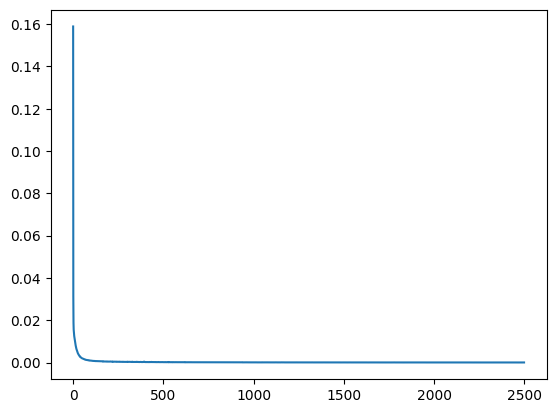

In [ ]:
plt.plot(loss_arr, label="loss")
# print(loss_arr[1500])
# print(loss_arr[2400])


(11026, 50, 1)
(11026, 50, 1)
torch.Size([11026])
(11095, 1)
44
(11095, 1)
torch.Size([11095])
mae :  0.7628698852090646
mse :  0.9208040202554529
rmse :  0.9595853376617699


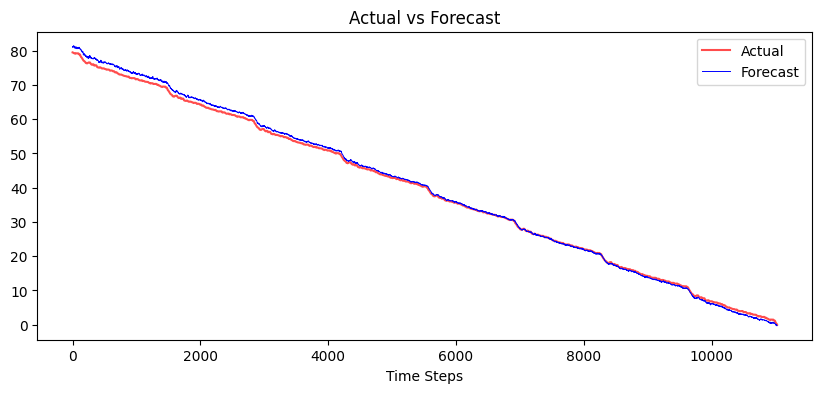

In [ ]:
eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
# eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
dataset_d = CustomDataset("FUDS_80.csv", 2586)
# dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)
print(dataset_d.y.shape)
print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

print(dataset_d.y.shape)
print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))




(11142, 50, 1)
(11142, 50, 1)
torch.Size([11142])
(11211, 1)
44
(11211, 1)
torch.Size([11211])
mae :  1.1602546297987482
mse :  1.946787079610461
rmse :  1.3952731200773778


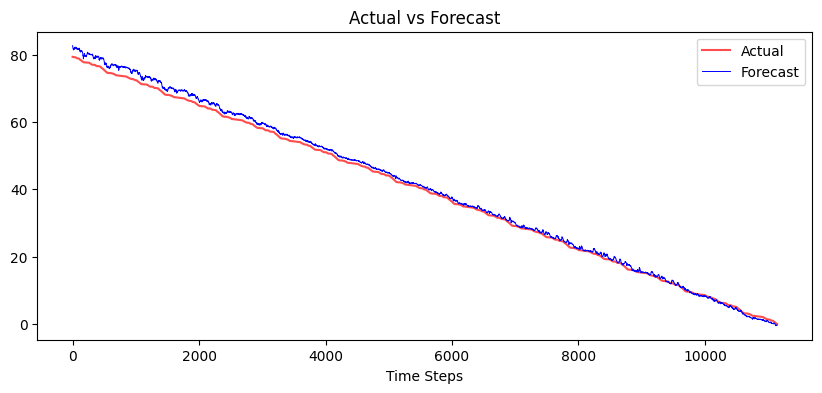

In [ ]:
# eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
# dataset_d = CustomDataset("FUDS_80.csv", 2586)
dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)
print(dataset_d.y.shape)
print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

print(dataset_d.y.shape)
print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))